https://learn.astropy.org/tutorials/quantities.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

%matplotlib inline

In [3]:
import astropy.units as u
from astropy.constants import G, h, k_B
from astropy.visualization import quantity_support

In [5]:
Reff = 29 * u.pc
print(
    """Half light radius
value: {0.value}
unit: {0.unit}""".format(Reff)
)
print("{0:.3g}".format(Reff.to(u.m)))

Half light radius
value: 29.0
unit: pc
8.95e+17 m


In [7]:
vmean = 206
sigin = 4.3
v = np.random.normal(vmean, sigin, 500) * u.km / u.s
print(
    """First 10 radial velocity measurements:
{0}
{1}""".format(v[:10], v.to(u.m / u.s)[:10])
)

First 10 radial velocity measurements: 
[207.64574945 205.85275819 210.71429144 204.99287205 204.50596219
 203.50054555 198.97967154 199.25859879 200.9296209  211.59614071] km / s
[207645.74944905 205852.75819371 210714.29143636 204992.87205422
 204505.96219426 203500.5455495  198979.67153719 199258.59878547
 200929.62089826 211596.14070816] m / s


In [8]:
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x1e6497cee10>

Text(0, 0.5, 'N')

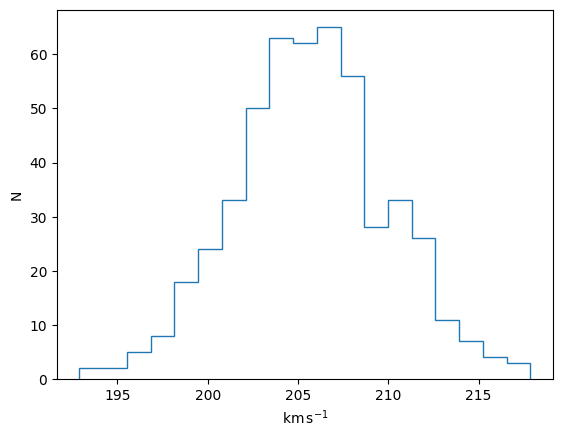

In [9]:
plt.figure()
plt.hist(v, bins="auto", histtype="step")
plt.ylabel("N")

In [12]:
sigma = np.sqrt(np.sum((v - np.mean(v)) ** 2) / np.size(v))
print("Velocity dispersion: {0:.2f}".format(sigma))
sigma_scalar = np.sqrt(np.sum((v - np.mean(v)) ** 2) / len(v))
print(sigma_scalar)

Velocity dispersion: 4.19 km / s
4.194119926849044 km / s


In [13]:
M = 4 * sigma**2 * Reff / G
print(M)
print(M.decompose())

30572711257388.777 km2 kg pc / m3
9.43375297323333e+35 kg


In [15]:
print(
    """Galaxy mass
    in solar units: {0:.3g}
    SI units: {1:.3g}
    CGS units: {2:.3g}
""".format(M.to(u.Msun), M.si, M.cgs)
)

Galaxy mass
    in solar units: 4.74e+05 solMass
    SI units: 9.43e+35 kg
    CGS units: 9.43e+38 g



In [19]:
d = 250 * u.pc
Tex = 25 * u.K

# Cloud's center
cen_ra = 52.25 * u.deg
cen_dec = 0.25 * u.deg
cen_v = 15 * u.km / u.s

# Cloud's size
sig_ra = 3 * u.arcmin
sig_dec = 4 * u.arcmin
sig_v = 3 * u.km / u.s

# 1D coordinate quantities
ra = np.linspace(52, 52.5, 100) * u.deg
dec = np.linspace(0, 0.5, 100) * u.deg
v = np.linspace(0, 30, 300) * u.km / u.s

# this creates data cubes of size for each coordinate based on the dimensions of the other coordinates
ra_cube, dec_cube, v_cube = np.meshgrid(ra, dec, v)

data_gauss = np.exp(
    -0.5 * ((ra_cube - cen_ra) / sig_ra) ** 2
    + -0.5 * ((dec_cube - cen_dec) / sig_dec) ** 2
    + -0.5 * ((v_cube - cen_v) / sig_v) ** 2
)

In [20]:
data = data_gauss * u.K

# Average pixel size
# This is only right if dec ~ 0, because of the cos(dec) factor.
dra = (ra.max() - ra.min()) / len(ra)
ddec = (dec.max() - dec.min()) / len(dec)

# Average velocity bin width
dv = (v.max() - v.min()) / len(v)
print(
    """dra = {0}
ddec = {1}
dv = {2}""".format(dra.to(u.arcsec), ddec.to(u.arcsec), dv)
)

dra = 18.0 arcsec
ddec = 18.0 arcsec
dv = 0.1 km / s


In [21]:
intcloud = np.sum(data * dv, axis=2)
intcloud.unit

Unit("K km / s")

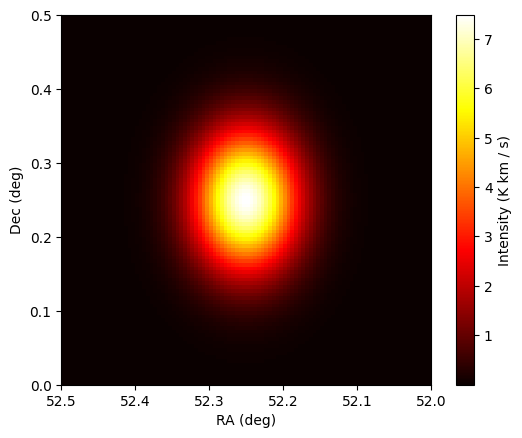

In [22]:
# Note that we display RA in the convential way by going from max to min
plt.imshow(
    intcloud.value,
    origin="lower",
    extent=[ra.value.max(), ra.value.min(), dec.value.min(), dec.value.max()],
    cmap="hot",
    interpolation="nearest",
    aspect="equal",
)
plt.colorbar().set_label("Intensity ({})".format(intcloud.unit))
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)");

In [24]:
lambda13 = 2.60076 * u.mm
lambda18 = 2.73079 * u.mm
nu13 = lambda13.to(u.Hz, equivalencies=u.spectral())
nu18 = lambda18.to(u.Hz, equivalencies=u.spectral())

In [25]:
nu13 = 115271096910.13396 * u.Hz
nu18 = 109782318669.689 * u.Hz
A13 = 7.4e-8 / u.s
A18 = 8.8e-8 / u.s

C = 3e14 * (nu18 / nu13) ** 3 * (A13 / A18) / (u.K * u.cm**2 * u.km * (1 / u.s))
C

<Quantity 2.17924582e+14 s / (K km cm2)>

In [26]:
B = h * nu18 / (k_B * Tex)
print("{0}\n{1}".format(B, B.decompose()))

0.21074881298143522 Hz s
0.21074881298143522


In [27]:
NCO = C * np.sum(data * dv, axis=2) / (1 - np.exp(-B))
print("Peak CO column density: ")
np.max(NCO)

Peak CO column density: 


<Quantity 8.5782091e+15 1 / cm2>

In [28]:
H2_CO_ratio = 5.9e6
NH2 = NCO * H2_CO_ratio
print("Peak H2 column density: ")
np.max(NH2)

Peak H2 column density: 


<Quantity 5.06114337e+22 1 / cm2>

In [37]:
mH2 = 2 * 1.008 * u.Dalton  # aka atomic mass unit/amu
rho = NH2 * mH2
dap = dra * ddec
print(dap)
da = (dap * d**2).to(u.pc**2, equivalencies=u.dimensionless_angles())
print(da)
print(da.to(u.cm**2))
M = np.sum(rho * da)
print(M.decompose().to(u.solMass))

2.5e-05 deg2
0.0004759647184167321 pc2
4.531853390889717e+33 cm2
317.6484309096624 solMass
